In [23]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [24]:
torch.__version__

'2.4.0'

In [25]:
device = torch.device("cuda")
device

device(type='cuda')

In [26]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [27]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [28]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [29]:
words[:10]

['the general third company to the commander the words passed along',
 'oh dear what a beast i am muttered rostov as he read the letter',
 'every day or may place me under arrest but no one can make me',
 '',
 'no longer in general use prince andrew remembered the story of suvorov',
 'or anyone else and i dont want anything of the kind',
 'know there will be time enough to think about love when i want to but',
 'shoulders shuddered as if a cold shiver had run down them how his left',
 'thou hatest it then change it purify thyself and as thou art',
 'captains voice began to tremble you have been in the regiment next to']

In [30]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [31]:
block_size = 5 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [32]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 5]), torch.int64, torch.Size([204978]), torch.int64)

In [33]:
emb_dim = 64
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[ 0.5872, -0.9739,  0.7046,  ...,  0.5335,  0.6697, -0.1482],
        [ 0.6979, -2.6450, -0.0577,  ...,  1.5395, -1.6789, -0.3581],
        [-0.2681, -0.2562,  2.2764,  ..., -0.1047, -0.2178, -0.5522],
        ...,
        [-1.2662,  1.3183, -1.5485,  ..., -1.1789,  0.7988, -0.2554],
        [ 1.4240,  1.1860, -0.3012,  ...,  1.2634,  3.8241, -1.2373],
        [-0.0999,  1.1386, -0.4706,  ..., -0.0750,  0.3152, -0.6429]],
       requires_grad=True)

In [34]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.tanh(self.lin1(x))
        x = self.lin2(x)
        return x 

In [35]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 512).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1027 12:43:48.669000 136499258763072 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/2531494610.py line 8 
W1027 12:43:48.669000 136499258763072 torch/_dynamo/convert_frame.py:1009] due to: 
W1027 12:43:48.669000 136499258763072 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1027 12:43:48.669000 136499258763072 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1027 12:43:48.669000 136499258763072 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1027 12:43:48.669000 136499258763072 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1027 12:43:48.669000 136499258763072 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1027 12:43:48.669000 136499258763072 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 spotune manifessto rectify independent oftener throne loaded reasoning inquiry summon breakfasting exquisite eight inhaling austerlitz markov made conspicuous wagged hieroglyphics quick tremble tied canceled curtseying interest scherers firing des springtime almighty crybaby domestic albums thwow recruiting thaler tenor renew crybaby ungainly crudele jokes lavater replaced revolution praise beyond longdrawn somber available collar knapsacks discovered thresh nearer treading exit guests find favor snubnosed largeboned merci conscientious pedal curiously clay hungarian drawingroom laden energetic feignedor temperature exertionsthe reckon comparison gay beauty lorrain bonfires smooth brindled bottle empress creation poor touch warrior detail turns secretary armies pining feelings upstairs invalidity wail answers reassuring
 careless beto perfectly guidance artificial travelers brindled reported runs watchful detail drinks iogels stones drunkenness strokes clanking veil austerity danser w

In [36]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 64])
_orig_mod.lin1.weight torch.Size([512, 320])
_orig_mod.lin1.bias torch.Size([512])
_orig_mod.lin2.weight torch.Size([11189, 512])
_orig_mod.lin2.bias torch.Size([11189])


In [37]:
len(stoi)

11189

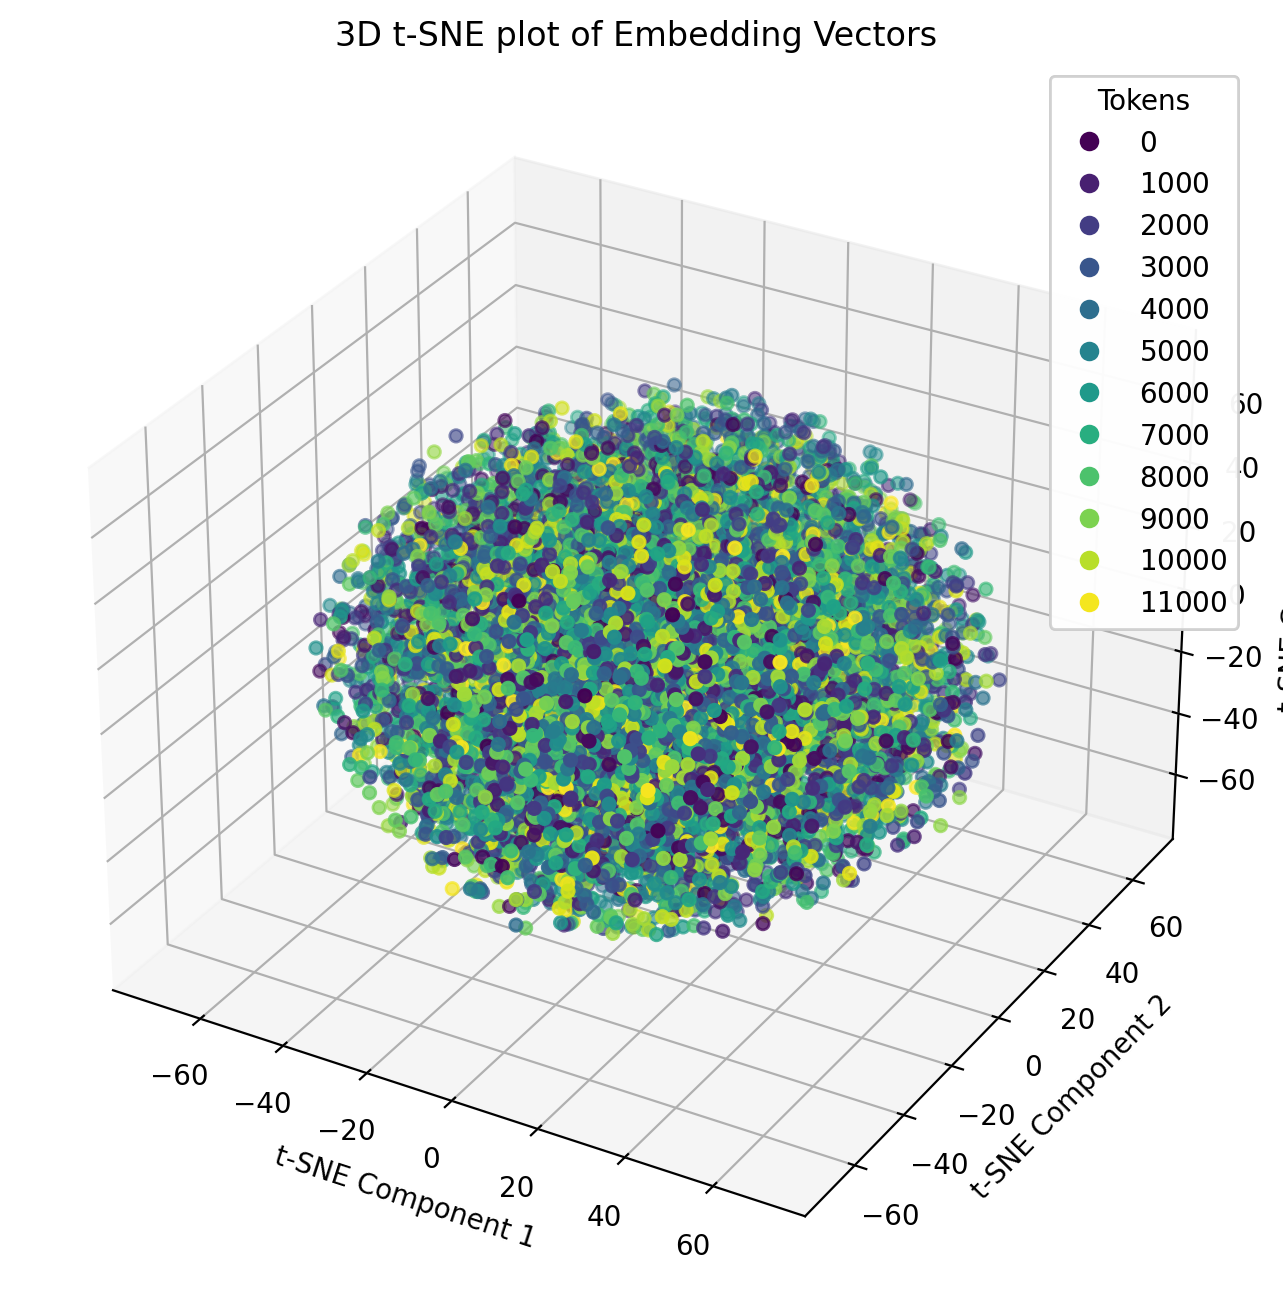

In [38]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

tokens = list(stoi.keys())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [39]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 13.735390663146973
Epoch 10, Loss: 10.549553871154785
Epoch 20, Loss: 9.71629524230957
Epoch 30, Loss: 9.173755645751953
Epoch 40, Loss: 8.747693061828613
Epoch 50, Loss: 8.384407043457031
Epoch 60, Loss: 8.058083534240723
Epoch 70, Loss: 7.755237102508545
Epoch 80, Loss: 7.468589782714844
Epoch 90, Loss: 7.194307804107666
Epoch 100, Loss: 6.930508613586426
Epoch 110, Loss: 6.676609992980957
Epoch 120, Loss: 6.432193756103516
Epoch 130, Loss: 6.197339057922363
Epoch 140, Loss: 5.972620964050293
Epoch 150, Loss: 5.758535861968994
Epoch 160, Loss: 5.555356979370117
Epoch 170, Loss: 5.363350868225098
Epoch 180, Loss: 5.182513236999512
Epoch 190, Loss: 5.012669563293457
Epoch 200, Loss: 4.853544235229492
Epoch 210, Loss: 4.704540252685547
Epoch 220, Loss: 4.5651164054870605
Epoch 230, Loss: 4.4346513748168945
Epoch 240, Loss: 4.312492370605469
Epoch 250, Loss: 4.198040962219238
Epoch 260, Loss: 4.090766906738281
Epoch 270, Loss: 3.9900519847869873
Epoch 280, Loss: 3.89542150

In [40]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 told him to me
 i was so against him had often success settled
 shall be heard
 yes i do they know mon
 ring it off makes on
 him not only at that moment well it is
 away and smiled affectionately stooping at every face and her sigh sprang her his retreat was
 amount the vicomte de chale beaming bore me is well said prince andrew wiping his nose
 
 eh


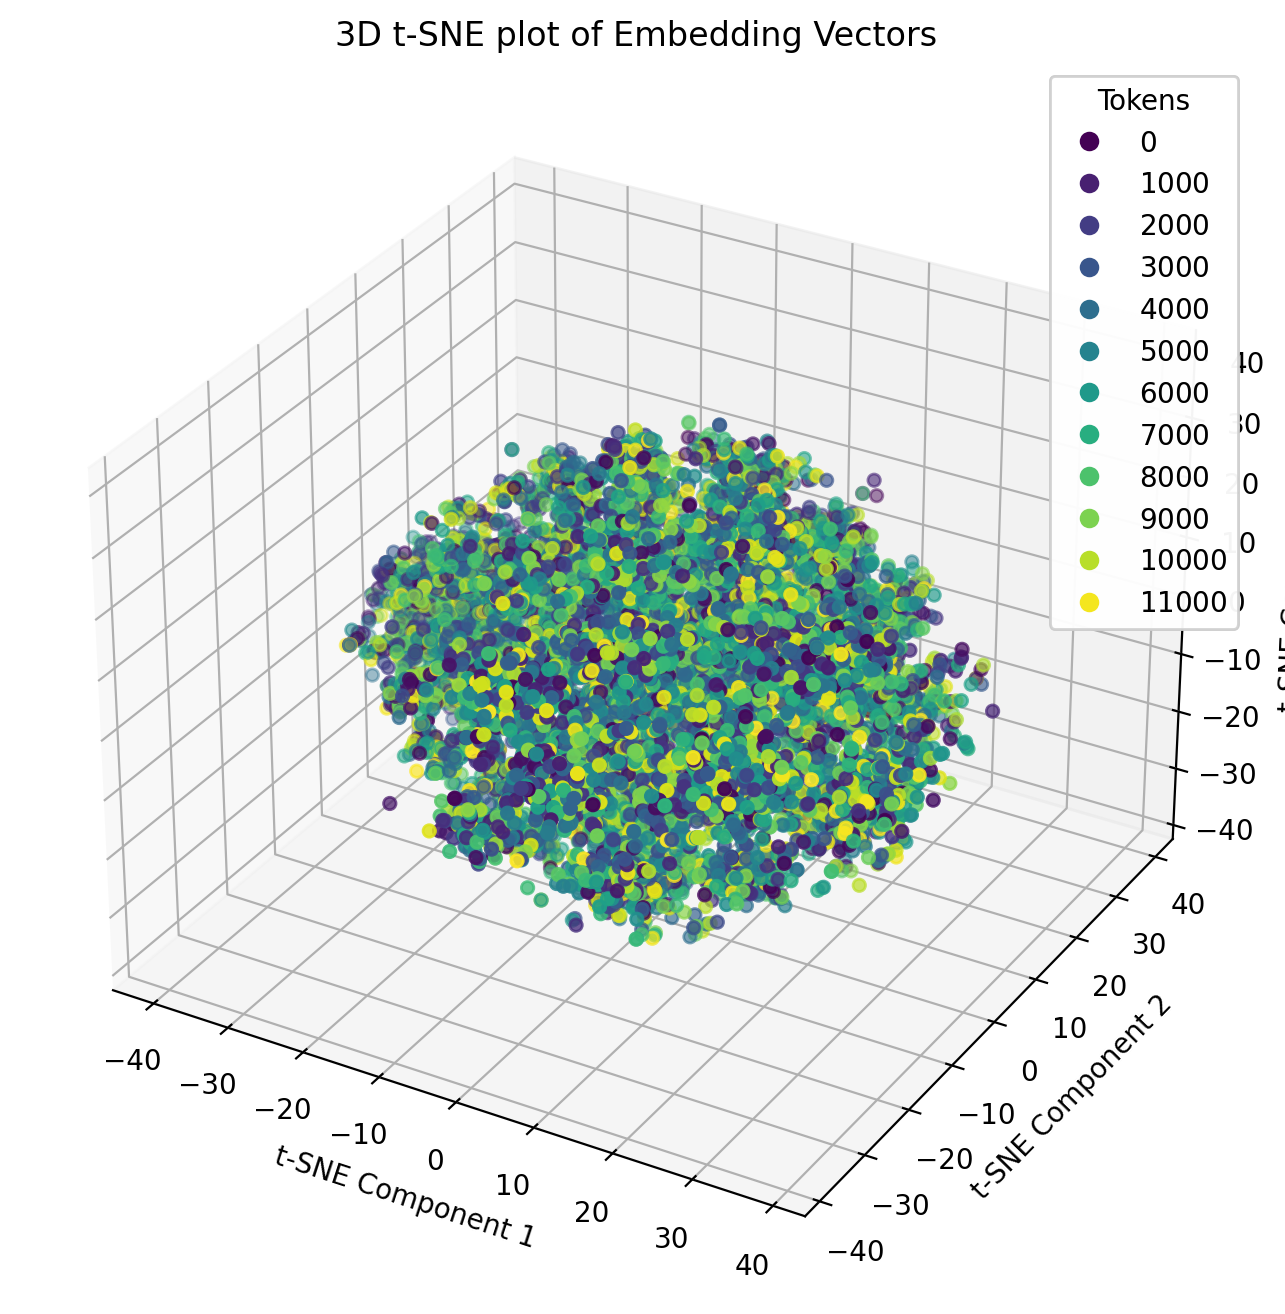

In [41]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [42]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_5_64_512_t.pth")

In [43]:
model = model.to(device)

In [44]:
pd_itos_i = [i for s,i in stoi.items()]
pd_itos_s = [s for s,i in stoi.items()]

pd_itos = pd.DataFrame({"i":pd_itos_i, "s":pd_itos_s})
pd_stoi = pd.DataFrame({"s":pd_itos_s, "i":pd_itos_i})

pd_itos.to_csv('itos.csv')
pd_stoi.to_csv('stoi.csv')